# Data Mining Final Project Group 6
Chirag Lakhanpal, Amy Sharp, and James Crim

# Setup

In [1]:
# code to widen the coding window (for James, idk if it will affect y'alls setups)
from IPython.core.display import display, HTML;
display(HTML("<style>.container { width:95% !important; }</style>"));

In [2]:
from scipy import stats

In [3]:
# package imports (jimbus)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import wbgapi as wb
import statsmodels.api as sm
import sklearn as skl

# sklearn subpackages
from sklearn import model_selection as mdl_slct
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RepeatedKFold
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# common
#import matplotlib.pyplot as plt
#import numpy as np
#import pandas as pd
#import matplotlib as mpl
#import matplotlib.pyplot as plt
#import statsmodels.api as sm

In [ ]:
# sklearn
#from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import train_test_split, KFold
#from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import mean_squared_error
#from sklearn import linear_model
#from sklearn.linear_model import LinearRegression
#from sklearn import model_selection
#from sklearn.model_selection import RepeatedKFold
#from sklearn.ensemble import RandomForestRegressor
#from statsmodels.stats.outliers_influence import variance_inflation_factor
#from sklearn.tree import DecisionTreeRegressor
#from sklearn import metrics
#from sklearn.preprocessing import StandardScaler

In [ ]:
# merf
#from merf import *
##from merf.evaluator import plot_bhat, plot_training_stats
#from merf.merf import MERF

In [ ]:
# plotting related imports
#import warnings
#import seaborn as seas
#warnings.filterwarnings('ignore')

In [ ]:
# misc imports
#import os, sys
#sys.path.append('..')
#from tabulate import tabulate
#import wbgapi as wb

In [36]:
# plotting settings
#%load_ext autoreload
#%autoreload 2
#%matplotlib inline
#seas.set(style="ticks", context="talk")
#plt.style.use("dark_background")
#seas.set_context("poster")

In [4]:
# set figure sizes
#mpl.rcParams['figure.figsize'] = (11,8)
plt.rcParams['figure.figsize'] = [24, 6]

In [5]:
# set seed (probably unescessary but couldn't hurt)
np.random.seed(2022)

# Import Data

In [6]:
# set up for importing data from API

# get set of country codes to use to import data from world bank
country_names_raw = pd.read_csv('CountrUsedN(1).csv', header=None)
country_names = country_names_raw.iloc[:, 0].to_list()
country_codes_list = list(wb.economy.coder(country_names).values())
country_codes_set = set(country_codes_list)

# years of interest ("since 1994")
year_list = range(1994, 2020)
year_list_strings = np.array(year_list).astype(str)

# the seven indexes to use (copied from WorldBankIndUsed.docx from the Data Mining Blackboard)
# note: CO2 emmissions per captia (CO2 kt / pop) is the outcome variable, the other x variables are predictor variables
world_bank_index_codes = ['EN.ATM.CO2E.KT', 'NY.GDP.MKTP.PP.KD',  'SP.POP.TOTL', 'EG.FEC.RNEW.ZS', 'SP.URB.TOTL.IN.ZS', 'NV.MNF.TECH.ZS.UN', 'NE.TRD.GNFS.ZS']

In [7]:
# import the data from the API
# URL of API package: https://pypi.org/project/wbgapi/
raw_dat = wb.data.DataFrame(world_bank_index_codes, country_codes_set, year_list, labels=True)

# swap around the way the three dimensions are multi-indexed such that country and then year are on the x axis (rows) and economic indicators are on the y axis (columns)
dat = raw_dat.pivot(index='Series', columns='Country').transpose().swaplevel().sort_index()

# remove missing data
dat = dat.dropna()

# detect any missing data, all zeros means no missing data
print('All zeros means no missing data')
print(np.sum(dat.isna()))

# create composite outcome variable
dat['CO2 Emissions (kt) per Capita'] = dat['CO2 emissions (kt)'] / dat['Population, total']

# names manually typed up (same order as indexes):
world_bank_index_names_short = ['CO2 emissions', 'GDP per capita', 'Perc Manufacturing Value Added', 'Total Population',
                                'Renewable energy consumption', 'Trade (% of GDP)', 'Urban Population', 'CO2 emissions per capita']
#world_bank_index_names_short = ['CO2 Emissions (kt)', 'GDP per Capita', '% Med/High Manufacturing', 'Total Population', 
#                                '% Renewable Energy', '% Trade of GDP', '% Urban', 'CO2 Emissions (kt) per Capita']

# renaming columns to shorter names (unused)
dat.columns = world_bank_index_names_short

# add year name to index
dat.index = dat.index.rename(['Country', 'Year'])

# save created data
dat.to_pickle("Data Mining Final Project Starting Data (WB Data).pkl")

# load created data
#dat = pd.read_pickle("Data Mining Final Project Starting Data (WB Data).pkl")

# rename dat to raw_dataset
raw_dataset = dat.copy()

All zeros means no missing data
Series
CO2 emissions (kt)                                                              0
GDP, PPP (constant 2017 international $)                                        0
Medium and high-tech manufacturing value added (% manufacturing value added)    0
Population, total                                                               0
Renewable energy consumption (% of total final energy consumption)              0
Trade (% of GDP)                                                                0
Urban population (% of total population)                                        0
dtype: int64


In [8]:
raw_dataset.columns

Index(['CO2 emissions', 'GDP per capita', 'Perc Manufacturing Value Added',
       'Total Population', 'Renewable energy consumption', 'Trade (% of GDP)',
       'Urban Population', 'CO2 emissions per capita'],
      dtype='object')

## Assorted Useful Functions for Getting Slices of the Data

In [9]:
# function to get a 2D dataframe of all country and measure data from a specific, single year
def get_year_data(year):
    return pd.DataFrame(dat.swaplevel().loc['YR'+str(year)])

# function to get a 2D dataframe of all years and measure data from a specific, single country
def get_country_data(country):
    return dat.loc[country]

# function to get a 1D multiplex dataframe of all years and all countries for a specific, single measure
def get_measure_data(measure_name):
    return pd.DataFrame(dat.loc[:, measure_name])

# function to get 1D multiplex dataframe of country data from a specific range of years for a specific measure
def get_specific_measures_for_specific_years(measure_name, year_start, year_end):
    year_end = year_end+1
    years_of_interest = np.char.add(np.repeat('YR', year_end-year_start), np.array(range(year_start, year_end)).astype(str))
    #print(years_of_interest_names)
    return pd.DataFrame(dat.swaplevel().loc[years_of_interest, measure_name])

# example use of functions
#get_country_data('United States')
#get_year_data(2003)
#get_measure_data('Population, total')
#get_specific_measures_for_specific_years(measure_name='Population, total', year_start=1994, year_end=2008)

# Overview/Descriptive Stats

In [10]:
# create function to get an overview of some base descriptive statistics
def get_data_overview(raw_dataset):
    col = ['Number of variables',
    'Number of observations',
    'Missing cells',
    'Missing cells (%)',
    'Rows with Missing cells',
    'Rows with Missing cells (%)',
    'Duplicate rows',
    'Duplicate rows (%)']

    val = [len(raw_dataset.columns),
    len(raw_dataset),
    raw_dataset.isna().values.sum(),
    (raw_dataset.isna().values.sum()/len(raw_dataset)) * 100,
    len(raw_dataset) - len(raw_dataset.dropna()),
    ((len(raw_dataset)-len(raw_dataset.dropna()))/len(raw_dataset)) * 100,
    raw_dataset.duplicated().sum(),
    raw_dataset.duplicated().sum()]

    val = list(map(round,val))

    return pd.DataFrame(zip(col,val), columns=['Variables', 'Count'])

# use overview function
overview = get_data_overview(raw_dataset)
overview

,Variables,Count
0,Number of variables,8
1,Number of observations,1443
2,Missing cells,0
3,Missing cells (%),0
4,Rows with Missing cells,0
5,Rows with Missing cells (%),0
6,Duplicate rows,0
7,Duplicate rows (%),0


# Side-by-Side Plots

In [11]:
def groupby_by_predictor_plot(ax, groupby_name, predictor_name):
    
    # set outcome variable name
    outcome_name = 'CO2 emissions per capita'
    
    # set labels
    ax.set_title(groupby_name)
    ax.set_xlabel(predictor_name)
    ax.set_ylabel(outcome_name)
    
    # make scatterplot between set predictor and outcome variables for country or year
    dat2plot = dat.groupby(groupby_name).mean()
    x2plot = dat2plot[predictor_name]
    y2plot = dat2plot[outcome_name]
    ax.scatter(x2plot, y2plot)
    
    # get list of text labels
    txt2plot = []
    if groupby_name == 'Country':
        txt2plot = country_names
    elif groupby_name == 'Year':
        txt2plot = year_list_strings
    
    # add text labels
    for i, txt in enumerate(txt2plot):
        ax.annotate(txt, (x2plot[i], y2plot[i]))

In [12]:
def side_by_side_plot(predictor_name):
    
    # create figure and title
    fig, axs = plt.subplots(1, 2);
    fig.suptitle(predictor_name);
    
    # create plots for country and year respectively
    groupby_by_predictor_plot(ax=axs[0], groupby_name='Country', predictor_name=predictor_name)
    groupby_by_predictor_plot(ax=axs[1], groupby_name='Year', predictor_name=predictor_name)

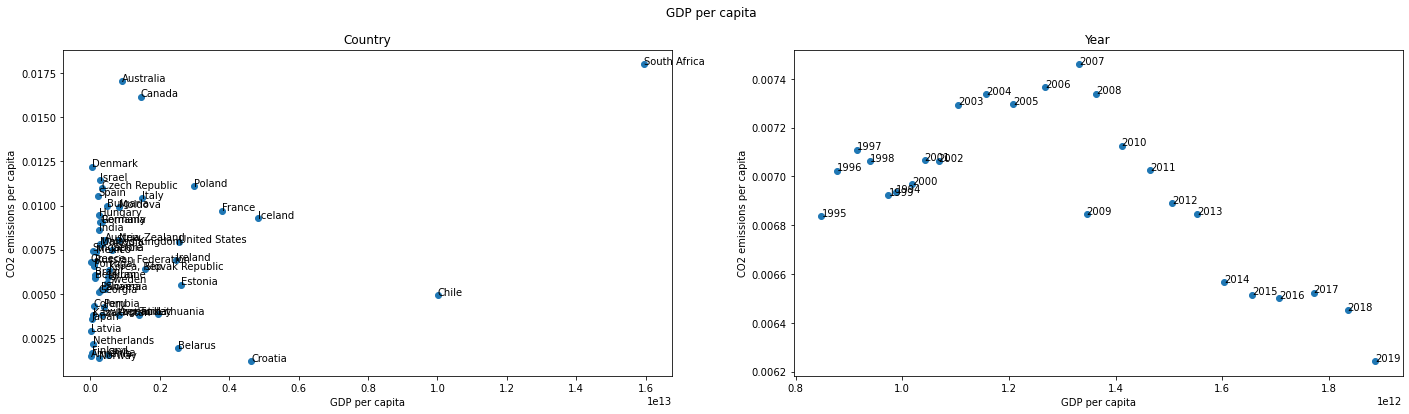

In [13]:
# plot the scatterplot of predicters against the outcome variable averaged across countries and years. Each point is labeled.
# Note that while many of the labels, particularly for countries, are overlapping and difficult to read, the outliers are easy to
# discern which is most important for this step of the project.
side_by_side_plot('GDP per capita')

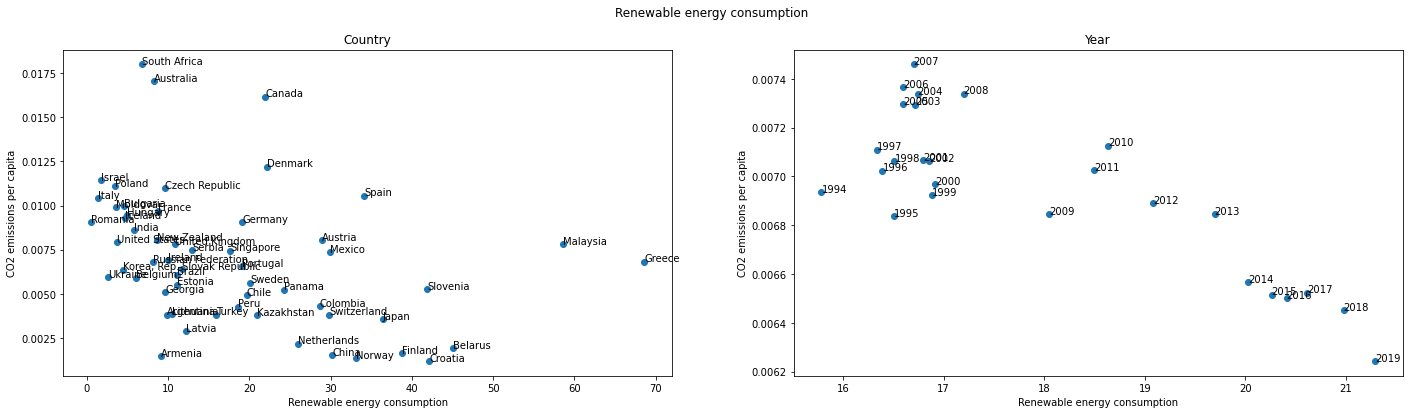

In [14]:
side_by_side_plot('Renewable energy consumption')

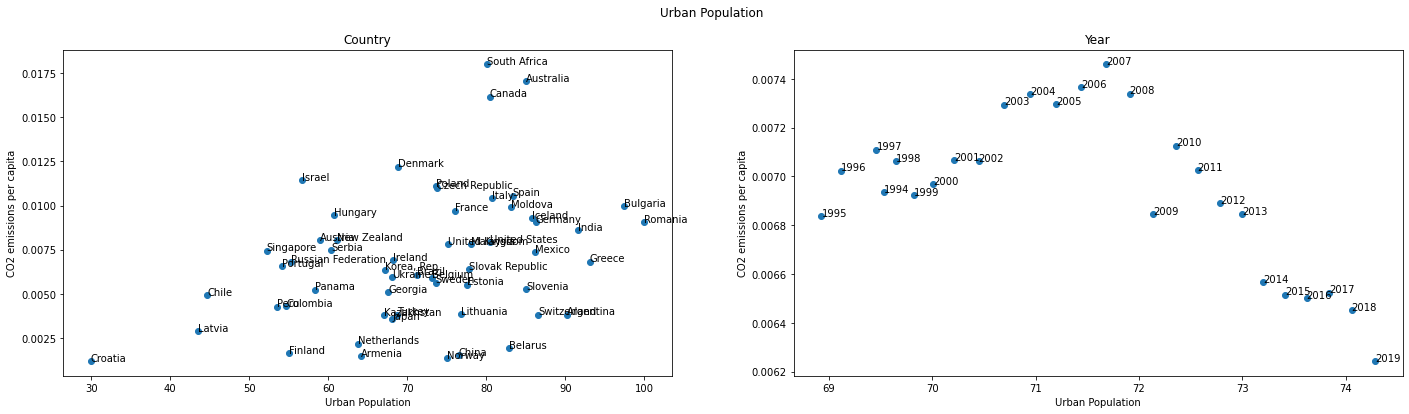

In [15]:
side_by_side_plot('Urban Population')

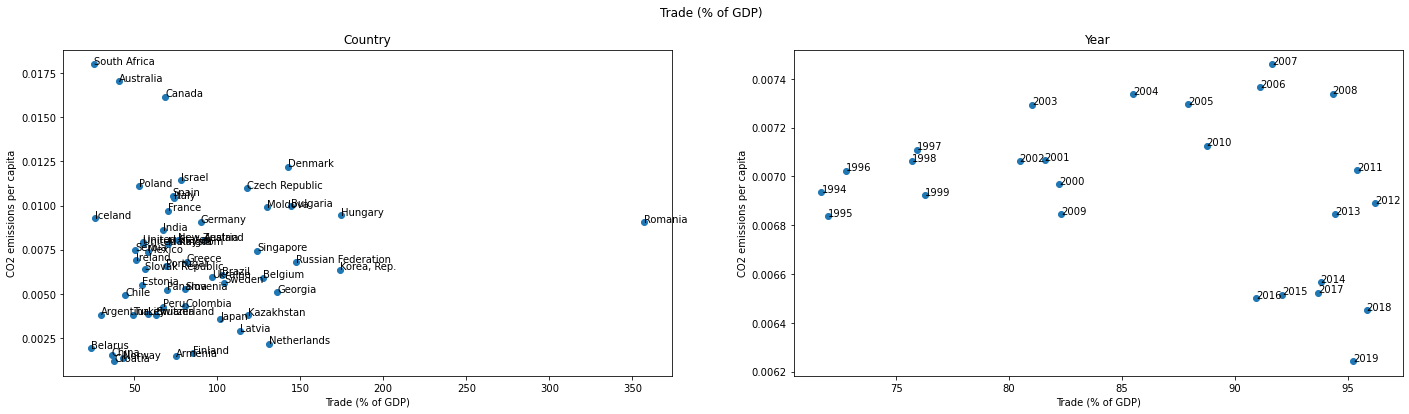

In [16]:
side_by_side_plot('Trade (% of GDP)')

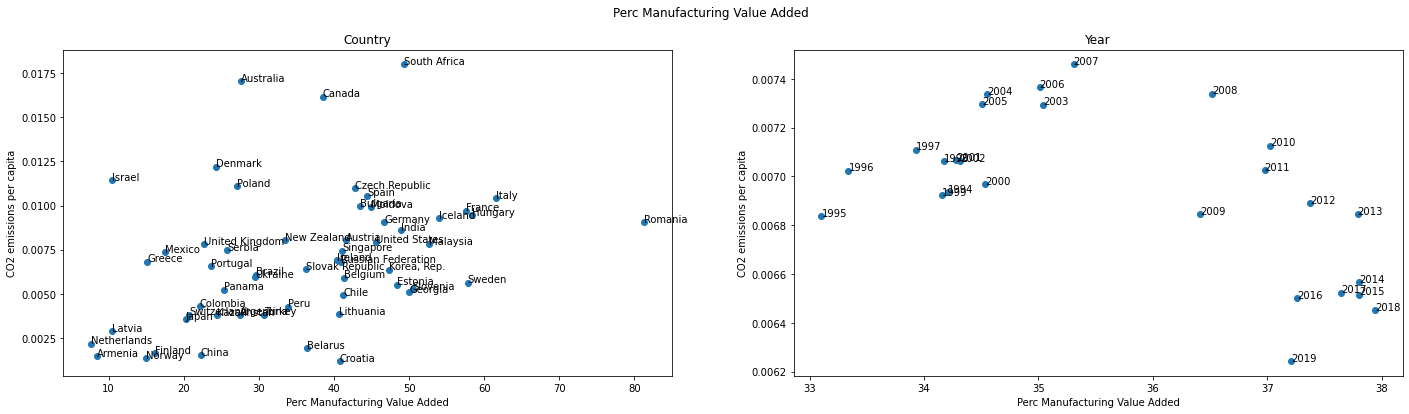

In [17]:
side_by_side_plot('Perc Manufacturing Value Added')

Notes: Overall no year for any measure looks like a particular outlier. However, for countries, Romania, South Africa, and Chile are all glaring outliers in at least one predictor measure, and so these plots would suggest they be removed as outliers.

# Outlier detection and treatment

In [18]:
def outlier_treatment(dataset):
    # outliers more than three sds away are replaced with the mean value of the column
    outlier_summary = []

    for col in dataset.columns[2:]:
        outliers = dataset[(np.abs(stats.zscore(dataset[col]))>3)][col]
        outlier_summary.append([col, len(outliers)])
        dataset.loc[outliers.index, col] = dataset[col].mean()

    outlier_summary = pd.DataFrame(outlier_summary, columns=['Variables', 'No. of Outliers'])

    return dataset, outlier_summary

# run function
raw_dataset_no_outliers = raw_dataset.copy()
raw_dataset_no_outliers, outlier_summary = outlier_treatment(raw_dataset_no_outliers)

outlier_summary

,Variables,No. of Outliers
0,Perc Manufacturing Value Added,10
1,Total Population,52
2,Renewable energy consumption,14
3,Trade (% of GDP),27
4,Urban Population,10
5,CO2 emissions per capita,15


# Log Trasforming the data

In [19]:
# log base 10 transform the data
processed_df = raw_dataset_no_outliers.copy()
for col in [col for col in processed_df.columns[2:]]:
    processed_df[col] = np.log10(processed_df[col] + 1)

# Data Summary (Post-Outlier Removal and Log Transformation)

In [20]:
# describe the cleaned data
processed_df.describe(include='all')

,CO2 emissions,GDP per capita,Perc Manufacturing Value Added,Total Population,Renewable energy consumption,Trade (% of GDP),Urban Population,CO2 emissions per capita
count,1.443000e+03,1.443000e+03,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000,1443.000000
mean,4.307898e+05,1.304783e+12,1.509789,7.179238,1.115691,1.863056,1.853878,0.002947
std,1.195953e+06,2.768642e+12,0.231886,0.607142,0.391837,0.218728,0.090003,0.001561
min,1.630000e+03,9.004634e+09,0.690589,5.427273,0.123852,1.158007,1.475715,0.000315
25%,3.829000e+04,1.514772e+11,1.405031,6.721371,0.867761,1.733932,1.797787,0.001768
50%,6.970000e+04,3.734972e+11,1.569113,7.035915,1.148911,1.866179,1.872180,0.002858
75%,3.353500e+05,1.222087e+12,1.674872,7.675878,1.445530,2.014420,1.916499,0.003854
max,1.070722e+07,2.249262e+13,1.924619,8.516311,1.802568,2.358700,2.004321,0.007877


# Distrobution Plots

In [34]:
# plotting settings
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.append('..')
%matplotlib inline
import seaborn as seas
seas.set(style="ticks", context="talk")
plt.style.use("dark_background")
#seas.set_context("poster")
import warnings
warnings.filterwarnings('ignore')


seas.set(style="ticks", context="talk")
plt.style.use("dark_background")
plt.style.use('default')
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


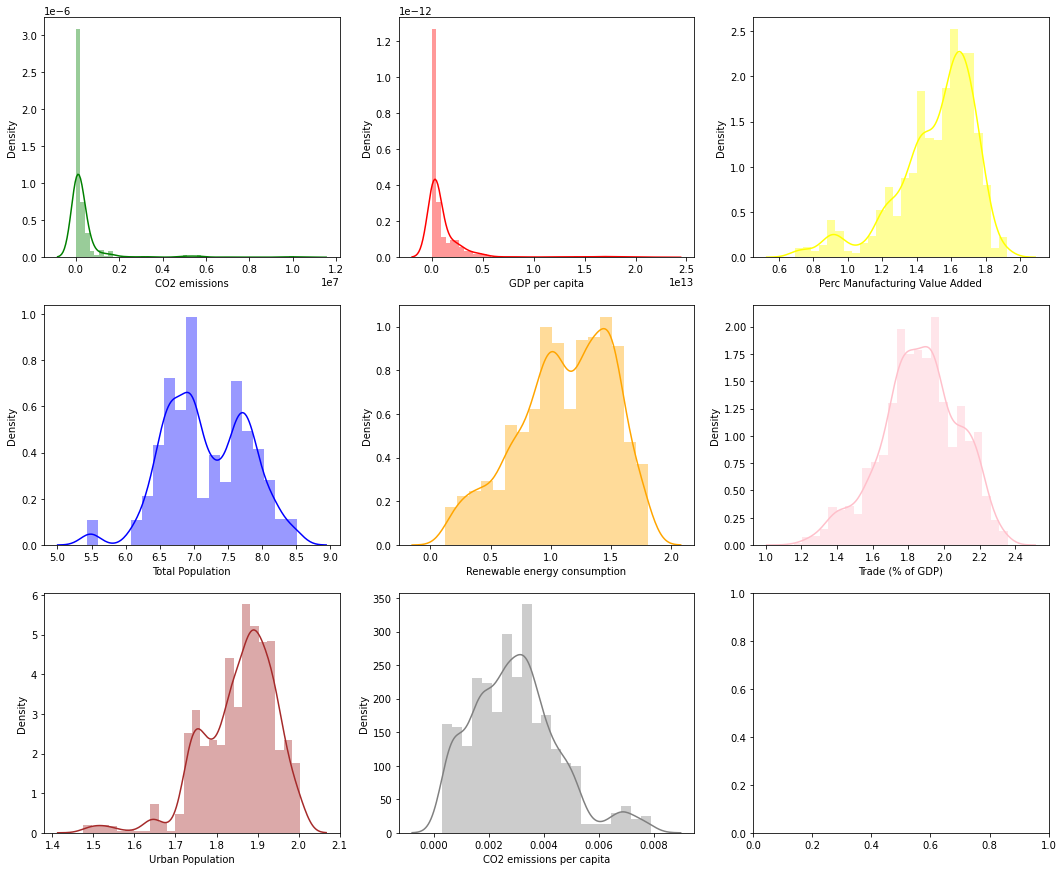

In [35]:
# plot
n_rows=3
n_cols=3
# Create the subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize = (18,15))

colors = {0:'green',1:'red',2:'yellow',3:'blue',4:'orange',5:'pink',6:'brown',7:'gray'}

for i, column in enumerate(processed_df.columns[0:]):
     seas.distplot(processed_df[column],color= colors[i],ax=axes[i//n_cols,i%n_cols]);

# Pair Plots

In [39]:
dat

CO2 emissions  GDP per capita  \
Country       Year                                    
Argentina     YR1994   1.119100e+05    6.224138e+11   
              YR1995   1.128900e+05    6.047048e+11   
              YR1996   1.225500e+05    6.381250e+11   
              YR1997   1.261200e+05    6.898836e+11   
              YR1998   1.326700e+05    7.164454e+11   
...                             ...             ...   
United States YR2015   4.990710e+06    1.873747e+13   
              YR2016   4.894500e+06    1.904991e+13   
              YR2017   4.819370e+06    1.947962e+13   
              YR2018   4.975310e+06    2.004820e+13   
              YR2019   4.817720e+06    2.050708e+13   

                      Perc Manufacturing Value Added  Total Population  \
Country       Year                                                       
Argentina     YR1994                       29.628354        34402669.0   
              YR1995                       27.200513        34828168.0   
              YR1996                       28.563551        35246376.0   
              YR1997                       30.983214        35657438.0   
              YR1998                       30.443321        36063451.0   
...                                              ...               ...   
United States YR2015                       48.323931       320738994.0   
              YR2016                       47.948956       323071755.0   
              YR2017                       48.313753       325122128.0   
              YR2018                       47.833288       326838199.0   
              YR2019                       47.054393       328329953.0   

                      Renewable energy consumption  Trade (% of GDP)  \
Country       Year                                                     
Argentina     YR1994                     10.734909         18.134346   
              YR1995                     11.205185         19.771423   
              YR1996                     10.193856         21.506468   
              YR1997                     10.999073         23.336179   
              YR1998                     11.343009         23.350028   
...                                            ...               ...   
United States YR2015                      9.030000         27.812234   
              YR2016                      9.460000         26.586999   
              YR2017                      9.920000         27.246163   
              YR2018                     10.120000         27.588858   
              YR2019                     10.420000         26.368922   

                      Urban Population  CO2 emissions per capita  
Country       Year                                                
Argentina     YR1994            87.960                  0.003253  
              YR1995            88.164                  0.003241  
              YR1996            88.366                  0.003477  
              YR1997            88.564                  0.003537  
              YR1998            88.759                  0.003679  
...                                ...                       ...  
United States YR2015            81.671                  0.015560  
              YR2016            81.862                  0.015150  
              YR2017            82.058                  0.014823  
              YR2018            82.256                  0.015223  
              YR2019            82.459                  0.014673  

[1443 rows x 8 columns]

In [59]:
temp

CO2 emissions  GDP per capita  \
Country       Year                                    
Argentina     YR1994   1.119100e+05    6.224138e+11   
              YR1995   1.128900e+05    6.047048e+11   
              YR1996   1.225500e+05    6.381250e+11   
              YR1997   1.261200e+05    6.898836e+11   
              YR1998   1.326700e+05    7.164454e+11   
...                             ...             ...   
United States YR2015   4.990710e+06    1.873747e+13   
              YR2016   4.894500e+06    1.904991e+13   
              YR2017   4.819370e+06    1.947962e+13   
              YR2018   4.975310e+06    2.004820e+13   
              YR2019   4.817720e+06    2.050708e+13   

                      Perc Manufacturing Value Added  Total Population  \
Country       Year                                                       
Argentina     YR1994                       29.628354        34402669.0   
              YR1995                       27.200513        34828168.0   
              YR1996                       28.563551        35246376.0   
              YR1997                       30.983214        35657438.0   
              YR1998                       30.443321        36063451.0   
...                                              ...               ...   
United States YR2015                       48.323931       320738994.0   
              YR2016                       47.948956       323071755.0   
              YR2017                       48.313753       325122128.0   
              YR2018                       47.833288       326838199.0   
              YR2019                       47.054393       328329953.0   

                      Renewable energy consumption  Trade (% of GDP)  \
Country       Year                                                     
Argentina     YR1994                     10.734909         18.134346   
              YR1995                     11.205185         19.771423   
              YR1996                     10.193856         21.506468   
              YR1997                     10.999073         23.336179   
              YR1998                     11.343009         23.350028   
...                                            ...               ...   
United States YR2015                      9.030000         27.812234   
              YR2016                      9.460000         26.586999   
              YR2017                      9.920000         27.246163   
              YR2018                     10.120000         27.588858   
              YR2019                     10.420000         26.368922   

                      Urban Population  CO2 emissions per capita  \
Country       Year                                                 
Argentina     YR1994            87.960                  0.003253   
              YR1995            88.164                  0.003241   
              YR1996            88.366                  0.003477   
              YR1997            88.564                  0.003537   
              YR1998            88.759                  0.003679   
...                                ...                       ...   
United States YR2015            81.671                  0.015560   
              YR2016            81.862                  0.015150   
              YR2017            82.058                  0.014823   
              YR2018            82.256                  0.015223   
              YR2019            82.459                  0.014673   

                                    index_col  
Country       Year                             
Argentina     YR1994      (Argentina, YR1994)  
              YR1995      (Argentina, YR1995)  
              YR1996      (Argentina, YR1996)  
              YR1997      (Argentina, YR1997)  
              YR1998      (Argentina, YR1998)  
...                                       ...  
United States YR2015  (United States, YR2015)  
              YR2016  (United States, YR2016)  
              YR2017  (United States, YR2

In [53]:
temp = dat.copy()

temp['index_col'] = temp.index
temp

CO2 emissions  GDP per capita  \
Country       Year                                    
Argentina     YR1994   1.119100e+05    6.224138e+11   
              YR1995   1.128900e+05    6.047048e+11   
              YR1996   1.225500e+05    6.381250e+11   
              YR1997   1.261200e+05    6.898836e+11   
              YR1998   1.326700e+05    7.164454e+11   
...                             ...             ...   
United States YR2015   4.990710e+06    1.873747e+13   
              YR2016   4.894500e+06    1.904991e+13   
              YR2017   4.819370e+06    1.947962e+13   
              YR2018   4.975310e+06    2.004820e+13   
              YR2019   4.817720e+06    2.050708e+13   

                      Perc Manufacturing Value Added  Total Population  \
Country       Year                                                       
Argentina     YR1994                       29.628354        34402669.0   
              YR1995                       27.200513        34828168.0   
              YR1996                       28.563551        35246376.0   
              YR1997                       30.983214        35657438.0   
              YR1998                       30.443321        36063451.0   
...                                              ...               ...   
United States YR2015                       48.323931       320738994.0   
              YR2016                       47.948956       323071755.0   
              YR2017                       48.313753       325122128.0   
              YR2018                       47.833288       326838199.0   
              YR2019                       47.054393       328329953.0   

                      Renewable energy consumption  Trade (% of GDP)  \
Country       Year                                                     
Argentina     YR1994                     10.734909         18.134346   
              YR1995                     11.205185         19.771423   
              YR1996                     10.193856         21.506468   
              YR1997                     10.999073         23.336179   
              YR1998                     11.343009         23.350028   
...                                            ...               ...   
United States YR2015                      9.030000         27.812234   
              YR2016                      9.460000         26.586999   
              YR2017                      9.920000         27.246163   
              YR2018                     10.120000         27.588858   
              YR2019                     10.420000         26.368922   

                      Urban Population  CO2 emissions per capita  \
Country       Year                                                 
Argentina     YR1994            87.960                  0.003253   
              YR1995            88.164                  0.003241   
              YR1996            88.366                  0.003477   
              YR1997            88.564                  0.003537   
              YR1998            88.759                  0.003679   
...                                ...                       ...   
United States YR2015            81.671                  0.015560   
              YR2016            81.862                  0.015150   
              YR2017            82.058                  0.014823   
              YR2018            82.256                  0.015223   
              YR2019            82.459                  0.014673   

                                    index_col  
Country       Year                             
Argentina     YR1994      (Argentina, YR1994)  
              YR1995      (Argentina, YR1995)  
              YR1996      (Argentina, YR1996)  
              YR1997      (Argentina, YR1997)  
              YR1998      (Argentina, YR1998)  
...                                       ...  
United States YR2015  (United States, YR2015)  
              YR2016  (United States, YR2016)  
              YR2017  (United States, YR2

In [60]:
#seas.pairplot(data=processed_df, hue='Country', palette="Set1")

In [61]:
#seas.pairplot(data=processed_df,  hue='Time',palette="Set1")

# Data Spliting

In [ ]:
X = processed_df.iloc[:,:-1]
y = processed_df.iloc[:,-1]
  
# using the train test split function
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=True)


In [ ]:
processed_df

In [ ]:
processed_df

In [ ]:
max_iter = 200
cv = KFold(n_splits=5, shuffle=True)
mse_rf = []
mse_rfplus = []
mse_mrf = []
mse_mrf_uranium = []
mse_mrf_uranium_both = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth

    # Mixed Effects Random Forest Training
    mrf = MERF(max_iterations=max_iter)
    X_train =  train.iloc[:,2:8]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    mrf.fit(X_train, Z_train, clusters_train, y_train)
    
    # Mixed Effects Random Forest Test
    X_test = train.iloc[:,2:8]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['Country']
    yhat_mrf = mrf.predict(X_test, Z_test, clusters_test)
    mse_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))

#train.iloc[:,2:8]

# Modeling

In [ ]:
max_iter = 200
cv = KFold(n_splits=5, shuffle=True)
mse_rf = []
mse_rfplus = []
mse_mrf = []
mse_mrf_uranium = []
mse_mrf_uranium_both = []

for train_idx, test_idx in cv.split(processed_df):
    # actually split the data
    train = processed_df.iloc[train_idx]
    test = processed_df.iloc[test_idx]
    # ground truth
    y = test['CO2 per Capita']
        
    # Mixed Effects Random Forest Training
    mrf = MERF(n_estimators=100, max_iterations=max_iter)
    X_train =  train.iloc[:,:]
    Z_train = np.ones((len(X_train), 1))
    clusters_train = train['Country']
    y_train = train['CO2 per Capita']
    mrf.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test
    X_test =  test[['floor']]
    Z_test = np.ones((len(X_test), 1))
    clusters_test = test['county']
    yhat_mrf = mrf.predict(X_test, Z_test, clusters_test)
    mse_mrf.append(np.sqrt(np.sum((y - yhat_mrf)**2)) / len(y))
    
    # Mixed Effects Random Forest Training with uranium RE
    mrf_uranium = MERF(n_estimators=100, max_iterations=max_iter)
    X_train =  train[['floor']]
    Z_train = np.array((np.ones(len(X_train)), train['Uppm'])).T
    clusters_train = train['county']
    y_train = train['log_radon']
    mrf_uranium.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with uranium RE
    X_test =  test[['floor']]
    Z_test = np.array((np.ones(len(X_test)), test['Uppm'])).T
    clusters_test = test['county']
    yhat_mrf_uranium = mrf_uranium.predict(X_test, Z_test, clusters_test)
    mse_mrf_uranium.append(np.sqrt(np.sum((y - yhat_mrf_uranium)**2)) / len(y))
    
    # Mixed Effects Random Forest Training with Uranium as both FE and RE
    mrf_uranium_both = MERF(n_estimators=100, max_iterations=max_iter)
    X_train =  train[['floor', 'Uppm']]
    Z_train = np.array((np.ones(len(X_train)), train['Uppm'])).T
    clusters_train = train['county']
    y_train = train['log_radon']
    mrf_uranium_both.fit(X_train, Z_train, clusters_train, y_train)

    # Mixed Effects Random Forest Test with County-level covariate (uranium)
    X_test =  test[['floor', 'Uppm']]
    Z_test = np.array((np.ones(len(X_test)), test['Uppm'])).T
    clusters_test = test['county']
    yhat_mrf_uranium_both = mrf_uranium_both.predict(X_test, Z_test, clusters_test)
    mse_mrf_uranium_both.append(np.sqrt(np.sum((y - yhat_mrf_uranium_both)**2)) / len(y))
